# MCX Data Processing

Processing data generated through *MCX Cloud* and saved in mcx-data

In [1]:
import jdata
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from datetime import datetime

In [2]:
def load_mcx_jnifti(path):
    """Load MCX output (.json JNIfTI format) and extract raw data."""
    data = jdata.load(path)
    array = np.array(data["NIFTIData"])
    return array

In [3]:
def reshape_to_TDHW(array):
    """
    Convert from [Z, Y, X, T, C=1] to [T, D, H, W].
    """
    if array.shape[-1] == 1:
        array = np.squeeze(array, axis=-1)  # → [Z, Y, X, T]
    Z, Y, X, T = array.shape
    return np.transpose(array, (3, 0, 1, 2))  # → [T, D, H, W]

In [4]:
def plot_decay(voxel_decay, label=None):
    plt.plot(voxel_decay, label=label)
    plt.xlabel("Time Bin")
    plt.ylabel("Fluence (a.u.)")
    plt.title("Photon Arrival Histogram")
    if label:
        plt.legend()
    plt.grid(True)

In [5]:
def save_mcx_as_npy(all_channels, output_dir='./output', metadata=None):
    """
    Save MCX simulation data as .npy files with metadata.
    
    Args:
        all_channels (np.ndarray): Stacked array of shape [C, T, D, H, W]
                                  (Channels, Time, Depth, Height, Width)
        output_dir (str): Directory to save files (created if doesn't exist)
        metadata (dict): Optional metadata to save as JSON
    
    Returns:
        dict: Paths to saved files
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save data
    data_path = os.path.join(output_dir, f'mcx_data_{timestamp}.npy')
    np.save(data_path, all_channels)
    
    # Save metadata
    meta_path = os.path.join(output_dir, f'mcx_metadata_{timestamp}.json')
    with open(meta_path, 'w') as f:
        json.dump(metadata or {}, f, indent=2)
    
    # Save individual channels (optional)
    channel_paths = []
    for c in range(all_channels.shape[0]):
        chan_path = os.path.join(output_dir, f'channel_{c}_{timestamp}.npy')
        np.save(chan_path, all_channels[c])
        channel_paths.append(chan_path)
    
    return {
        'data': data_path,
        'metadata': meta_path,
        'channels': channel_paths
    }

In [6]:
channel_files = [
    "ch1_520nm.json",
    "ch2_580nm.json",
    "ch3_650nm.json"
]

all_channels = []

for path in channel_files:
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue
    print(f"Loading {path}")
    data_raw = load_mcx_jnifti(path)
    data_tdhw = reshape_to_TDHW(data_raw)
    all_channels.append(data_tdhw)

# Stack across channel dimension
data = np.stack(all_channels, axis=0)  # [C, T, D, H, W]
print(f"\n Final data shape: {data.shape} (C, T, D, H, W)")

Loading ch1_520nm.json
Loading ch2_580nm.json
Loading ch3_650nm.json

 Final data shape: (3, 64, 60, 60, 60) (C, T, D, H, W)


In [7]:
# Save as npy with metadata
metadata = {
    'wavelengths': [520, 580, 650],  # nm
    'voxel_size': [1.0, 1.0, 1.0],  # mm
    'units': 'W/mm²'
}

# Save files
paths = save_mcx_as_npy(data, metadata=metadata)
print(f"Saved data to: {paths['data']}")
print(f"Metadata: {paths['metadata']}")

Saved data to: ./output/mcx_data_20250617_211748.npy
Metadata: ./output/mcx_metadata_20250617_211748.json


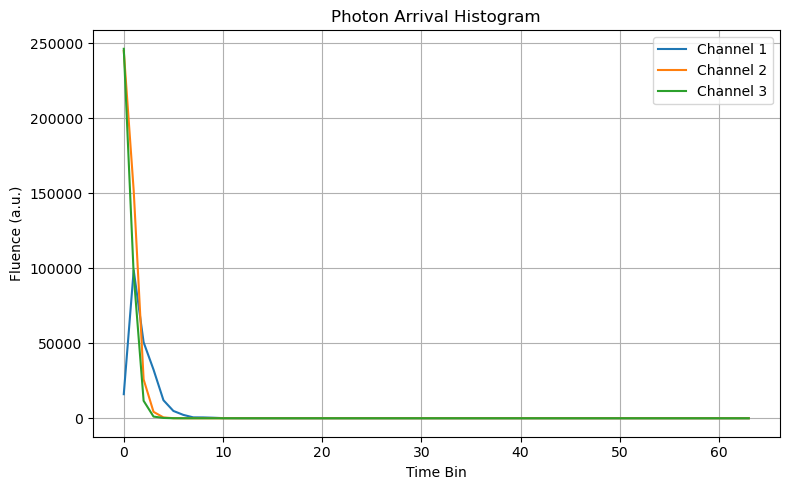

In [8]:
# Visualization -> Pick voxel (center by default)
C, T, D, H, W = data.shape
z, y, x = D // 2, H // 2, W // 2

plt.figure(figsize=(8, 5))
for c in range(C):
    decay = data[c, :, z, y, x]
    plot_decay(decay, label=f"Channel {c+1}")
plt.tight_layout()
plt.show(block=True)